In [1]:
import pretty_midi
import symusic
import mido
import numpy as np
import joblib
import glob
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns
# sns.set_style('white')
# sns.set_context('notebook', font_scale=1.5)
import matplotlib.gridspec
import collections
import os
from pathlib import Path
# plotting.py contains utility functions for making nice histogram plots
import util.plotting as plotting
from util.play_midi import play_midi
from statistics import mean, stdev, variance
import random
import miditok
import pandas as pd
from tqdm import tqdm 

from huggingface_hub import notebook_login
import ipywidgets


In [2]:
import mido
from mido import MidiFile, MidiTrack

def staty(listy):
    return (mean(listy), max(listy), min(listy), stdev(listy))

def append_midi_files(file1, file2, output_file):
    midi1 = MidiFile(file1)
    midi2 = MidiFile(file2)

    midi1_length_ticks = max(sum(msg.time for msg in track) for track in midi1.tracks)

    new_midi = MidiFile(ticks_per_beat=midi1.ticks_per_beat)

    for track in midi1.tracks:
        new_track = mido.MidiTrack()
        for msg in track:
            new_track.append(msg)
        new_midi.tracks.append(new_track)

    for track in midi2.tracks:
        new_track = mido.MidiTrack()
        first_msg = True
        for msg in track:
            if first_msg:
                msg.time += midi1_length_ticks
                first_msg = False
            new_track.append(msg)
        new_midi.tracks.append(new_track)

    # Save the new MIDI file
    new_midi.save(output_file)
    return output_file

In [3]:
if "lofi_radio" in os.getcwd().split(os.sep)[-1].lower():
    os.chdir("..")

# if os.chdir("..")
print(os.getcwd())

midi_files = [str(file) for file in Path("lmd_full/").glob("**/*.mid")]
# midi_files2 = list(Path("data/").glob("**/*.mid"))
# midi_files3 = list(Path("nottingham-dataset-master/nottingham-dataset-master/MIDI").glob("*.mid"))

# midi_files = glob.glob("lmd_full/**/*.mid")#  + glob.glob("/content/lmd_full/**/**/*.midi")
original_len = len(midi_files)
# os.chdir("/lofi_radio/")
len(midi_files)

c:\Users\joeac\Documents\Uni\Y3\Project


178561

In [4]:
def compute_statistics(midi_file):
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)
        # symusic.Score(midi_file)
        return {'n_instruments': len(pm.instruments),
                'program_numbers': [i.program for i in pm.instruments if not i.is_drum],
                'key_numbers': [k.key_number for k in pm.key_signature_changes],
                'tempos': list(pm.get_tempo_changes()[1]),
                'time_signature_changes': pm.time_signature_changes,
                'end_time': pm.get_end_time(),
                }
    except Exception as e:
        return {'n_instruments': None,
                'program_numbers': None,
                'key_numbers': None,
                'tempos': None,
                'time_signature_changes': None,
                'end_time': None,
                }

In [4]:
statistics_original = joblib.Parallel(n_jobs=10, verbose=1)(
    joblib.delayed(compute_statistics)(midi_file)
    for midi_file in midi_files)

statistics = [s for s in statistics_original if s is not None] # ONLY FOR VISUALISATION

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   11.1s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   18.6s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   28.4s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:   40.3s
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:   54.9s
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 6710 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 9010 tasks      | elapsed:  3.1min
[Parallel(n_jobs=10)]: Done 11510 tasks      | elapsed:  3.9min
[Parallel(n_jobs=10)]: Done 14210 tasks      | elapsed:  4.7min
[Parallel(n_jobs=10)]: Done 17110 tasks    

##### PREPROCESSING REMOVAL

In [7]:
### RUN FIRST ITERATION ONLY
indexes_to_remove = []
indexes_to_concatenate = []
for i,s in enumerate(statistics_original):
    if s["end_time"] is None: # CORRUPT FILES
        indexes_to_remove.append(i)
        continue
    if s["end_time"] < 75:
        indexes_to_remove.append(i)
        continue
    if mean(s["tempos"]) < 50 or mean(s["tempos"]) > 165:
        indexes_to_remove.append(i)
        continue
    if s["n_instruments"] >= 17:
        indexes_to_remove.append(i)
        continue
    if s["end_time"] >= 75 and s["end_time"] <= 150: # after others as only good quality music gets concatinated
        indexes_to_concatenate.append(i)

print(len(indexes_to_remove))
print(len(indexes_to_concatenate))

remove_indexes = {"remove" : indexes_to_remove}

remove_indexes_df = pd.DataFrame.from_dict(remove_indexes)
remove_indexes_df.to_csv("indexes_remove.csv")

concat_indexes = {"concatenate": indexes_to_concatenate}

concat_indexes_df = pd.DataFrame.from_dict(concat_indexes)
concat_indexes_df.to_csv("indexes_concat.csv")


52456
26398


In [12]:
remove_indexes = pd.read_csv("indexes_remove.csv")
concat_indexes = pd.read_csv("indexes_concat.csv")

remove_indexes = list(remove_indexes["remove"])
concat_indexes = list(concat_indexes["concatenate"])
print(len(remove_indexes))
print(len(concat_indexes))



52456
26398


In [15]:
print(concat_indexes[:10])
random.shuffle(concat_indexes)
print(concat_indexes[:10])
# i = 1
# output_file_name = f"lmd_new/output{i}"
# new_midi_files.append(append_midi_files(i,i+1,output_file_name))
# symusic.Score(output_file_name)
# play_midi(output_file_name)

[1, 6, 14, 24, 29, 35, 37, 50, 53, 68]
[3715, 34582, 91369, 99829, 5671, 86094, 110416, 95272, 41800, 111118]


In [17]:
from tqdm import tqdm 
 
random.shuffle(concat_indexes) # to concat randomly
new_midi_files = []
corrupt_new_files = []
for i in tqdm(range(0,len(concat_indexes), 2)):
    try:
        output_file_name = f"lmd_new/output{i}"
        new_midi_files.append(append_midi_files(midi_files[i],midi_files[i+1],output_file_name))
        # symusic.Score(output_file_name)
    except Exception as e:
        corrupt_new_files.append(output_file_name)
        new_midi_files.pop()
print(f"corrupt in this section = {len(corrupt_new_files)}")
print(f"num songs concatenated = {len(new_midi_files)}")


100%|██████████| 13199/13199 [48:10<00:00,  4.57it/s] 

corrupt in this section = 565
num songs concatenated = 12069


In [19]:
healthy_midi_files = {"file_names" : [midi_file for i,midi_file in enumerate(midi_files) if i not in remove_indexes] + new_midi_files}

print(len(healthy_midi_files["file_names"]))

138174


In [40]:
print(f"files to remove: {len(remove_indexes)}")
print(f"files to concatenate: {len(concat_indexes)}")

print(f"files in lmd: {len(midi_files)}")
print(f"files after all processing(except tokenization compatibilty): {len(healthy_midi_files['file_names'])}")
print(f"difference = {len(midi_files)-len(healthy_midi_files['file_names'])} which is {((len(midi_files)-len(healthy_midi_files['file_names']))/len(midi_files))*100:.1f}% of original dataset")
print(f"number of concatinated songs: {len(new_midi_files)}")

files to remove: 52456
files to concatenate: 26398
files in lmd: 178561
files after all processing(except tokenization compatibilty): 138174
difference = 40387 which is 22.6% of original dataset
number of concatinated songs: 12069


In [41]:
output_df = pd.DataFrame(healthy_midi_files)
output_df.to_csv("healthy_file_names.csv")

In [44]:
from miditok.pytorch_data import DatasetMIDI

tokenizer_config = miditok.TokenizerConfig(use_programs=True, one_token_stream_for_programs=True)
tokenizer = miditok.REMI(tokenizer_config)
tokenizer.one_token_stream = True
print(len(tokenizer))


411


C:\Users\joeac\AppData\Local\Temp\ipykernel_20336\1277365479.py:3: UserWarning: The special token PAD_None is present twice in your configuration. Skipping its duplicated occurrence.
  tokenizer_config = miditok.TokenizerConfig(use_programs=True, one_token_stream_for_programs=True)


In [48]:
midi_files2 = list(Path("lofi_radio-1/data/").glob("**/*.mid"))
midi_files3 = list(Path("nottingham-dataset-master/nottingham-dataset-master/MIDI").glob("*.mid"))

training_file_names = healthy_midi_files["file_names"][:2000]+midi_files2[:500]+midi_files3[:500]

print(len(midi_files2))
print(len(midi_files3))
print(len(training_file_names))


940
1034
3000


In [85]:
print(new_midi_files[:10])

['lmd_new/output0', 'lmd_new/output2', 'lmd_new/output4', 'lmd_new/output6', 'lmd_new/output8', 'lmd_new/output10', 'lmd_new/output12', 'lmd_new/output18', 'lmd_new/output20', 'lmd_new/output22']


In [ ]:
import shutil
import os



destination_folder = 'pretraining_dataset'

os.makedirs(destination_folder, exist_ok=True)

for file_path in tqdm(healthy_midi_files["file_names"]):
    new_path = os.path.join(destination_folder, os.path.basename(file_path))
    shutil.move(file_path, new_path)
    print(f'Moved {file_path} to {new_path}')

In [92]:
for filename in tqdm(os.listdir(destination_folder)):
    if filename[-4:] != ".mid":
        old_file = os.path.join(destination_folder, filename)
        new_file = os.path.join(destination_folder, filename+".mid")
        os.rename(old_file, new_file)

100%|██████████| 138174/138174 [00:00<00:00, 3292170.17it/s]


In [100]:
notebook_login()

In [98]:
vocab_size = 12_500
tokenizer.train(vocab_size=vocab_size, files_paths=training_file_names)
print(len(tokenizer))

12500


In [101]:
tokenizer.push_to_hub("theglassofwater/remi_12500",)

CommitInfo(commit_url='https://huggingface.co/theglassofwater/remi_12500/commit/a35b3218eafeb68813322a810378c3b0e99417d6', commit_message='Push model using huggingface_hub.', commit_description='', oid='a35b3218eafeb68813322a810378c3b0e99417d6', pr_url=None, pr_revision=None, pr_num=None)

In [103]:
seq_len = 100_000
full_dataset = DatasetMIDI(
    files_paths=healthy_midi_files["file_names"],
    max_seq_len=seq_len+1,  # max_seq_len = start + seq_len + end
    tokenizer=tokenizer,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
)

In [107]:
# full_dataset[0]["input_ids"]
x = [[1,2,4,5,6,6,3,3],[1,2,4,5,4,6,6,6,66],[1,2,3,4,5,6,7]]
arghh = pd.DataFrame({"x":x})
arghh

,x
0,"[1, 2, 4, 5, 6, 6, 3, 3]"
1,"[1, 2, 4, 5, 4, 6, 6, 6, 66]"
2,"[1, 2, 3, 4, 5, 6, 7]"


In [ ]:
def tokenize_file(file):
    # if file["input_ids"] ==None:print("sddfdf")
    # return file["input_ids"]
    try:
        tokenized_file = file["input_ids"]
        return tokenized_file
    except:
        return None
# tokenized_lengths = []
# corrupt_file_index=[]
# for i,file in tqdm(enumerate(full_dataset)):
#     try:
#         print(len(file["input_ids"]))
#         tokenized_lengths.append(len(file["input_ids"]))
#     except:
#         corrupt_file_index.append(i)



statistics_original = joblib.Parallel(n_jobs=12, verbose=1)(
    joblib.delayed(tokenize_file)(midi_file)
    for midi_file in full_dataset)

# print(f"corrupt files: {len(corrupt_file_index)}")
# print(f"mean,max,min,stdev : {staty(tokenized_lengths)}")

In [64]:
statistics_original

NameError: name 'statistics_original' is not defined

In [79]:
print(len(tokenized_lengths))

304


### VISUALISATION and UNDERSTANDING

31055.625


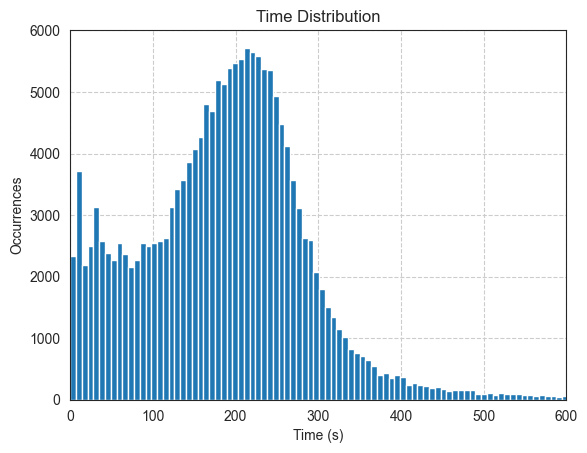

In [81]:
times = [s['end_time'] for s in statistics]
time_stats = staty(times)
print(f"mean,max,min,stdev : {time_stats}")

fig, ax = plt.subplots()
ax.hist([s['end_time'] for s in statistics if s["end_time"] <= 700], bins=100)
ax.set_xlim(0,600)
ax.set_ylabel("Occurrences")
ax.set_xlabel("Time (s)")
ax.grid(True, linestyle="--")
ax.set_title("Time Distribution")
plt.show()


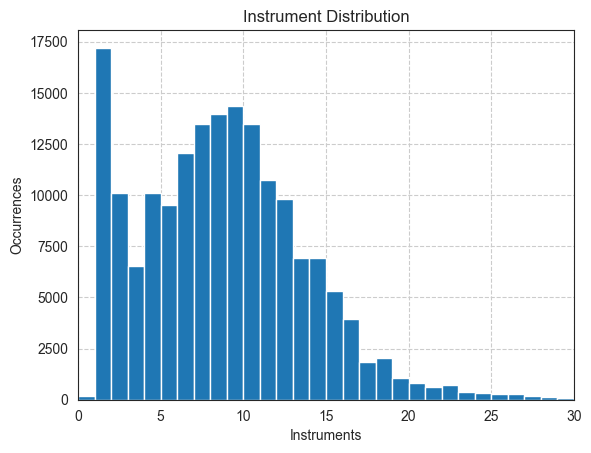

In [80]:

fig, ax = plt.subplots()
ax.hist([s['n_instruments'] for s in statistics if s["n_instruments"]<= 50], bins=50)
ax.set_xlim(0,30)
ax.set_ylabel("Occurrences")
ax.set_xlabel("Instruments")
ax.grid(True, linestyle="--")
ax.set_title("Instrument Distribution")
plt.show()


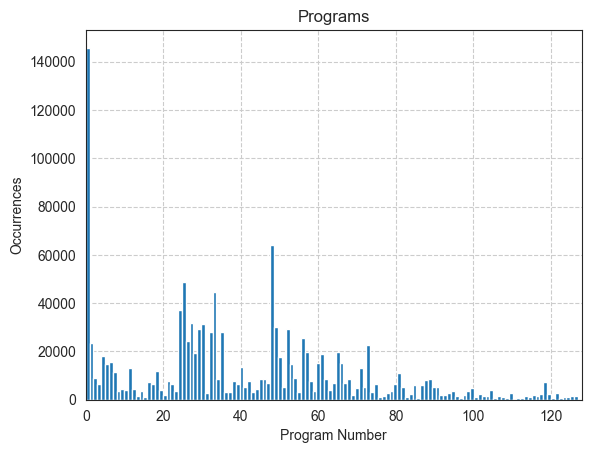

In [79]:
fig, ax = plt.subplots()
ax.hist([i for s in statistics for i in s['program_numbers']], bins=128)
ax.set_xlim(0,128)
ax.set_ylabel("Occurrences")
ax.set_xlabel("Program Number")
ax.grid(True, linestyle="--")
ax.set_title("Program Distribution")
plt.show()


overall tempo
mean,max,min,stdev : (110.1897934467098, 7303.712720632989, 4.0, 48.44704127749227)
tempo per song
mean,max,min,stdev : (114.11071581927331, 900.0090000900009, 10.0, 34.645736908662755)


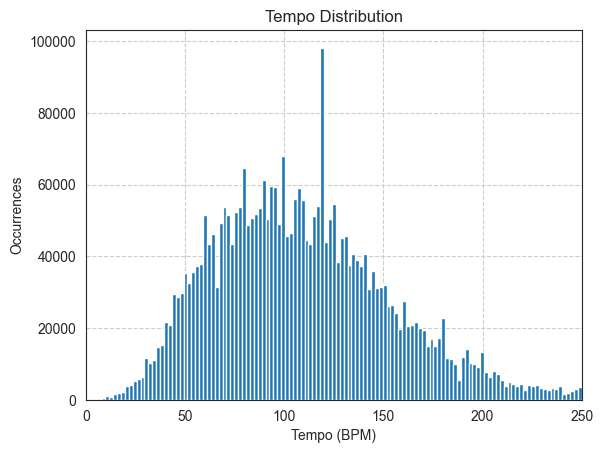

In [103]:
print("overall tempo")
tempos = [i for s in statistics for i in s['tempos']]
tempo_stats = staty(tempos)
print(f"mean,max,min,stdev : {tempo_stats}")

print("tempo per song")
tempos = [mean(s["tempos"]) for s in statistics]
tempo_stats = staty(tempos)
print(f"mean,max,min,stdev : {tempo_stats}")

fig, ax = plt.subplots()
ax.hist([i for s in statistics for i in s['tempos'] if i <=250], bins=125)
ax.set_xlim(0,250)
ax.set_ylabel("Occurrences")
ax.set_xlabel("Tempo (BPM)")
ax.grid(True, linestyle="--")
ax.set_title("Tempo Distribution")
plt.show()


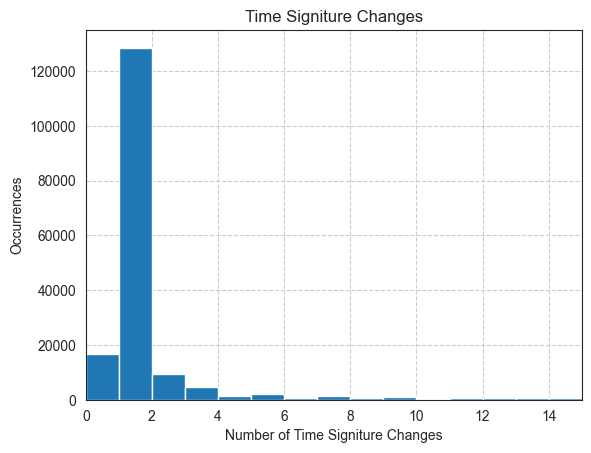

In [120]:
# plotting.plot_hist([len(s['time_signature_changes']) for s in statistics], range(12),
#                    'Number of time signature changes', 'Thousands of MIDI files')
# plt.xticks(range(11), range(10) + ['10+']);

fig, ax = plt.subplots()
ax.hist([len(s['time_signature_changes']) for s in statistics if len(s['time_signature_changes']) <= 15], bins=15)
ax.set_xlim(0,15)
ax.set_ylabel("Occurrences")
ax.set_xlabel("Number of Time Signiture Changes")
ax.grid(True, linestyle="--")
ax.set_title("Time Signiture Changes")
plt.show()

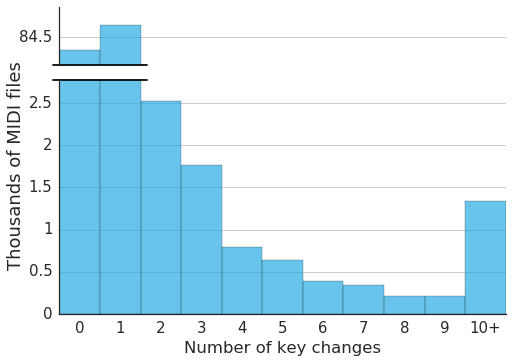

In [11]:
plotting.plot_hist([len(s['key_numbers']) for s in statistics], range(12),
                   'Number of key changes', 'Thousands of MIDI files')
plt.xticks(range(11), range(10) + ['10+']);

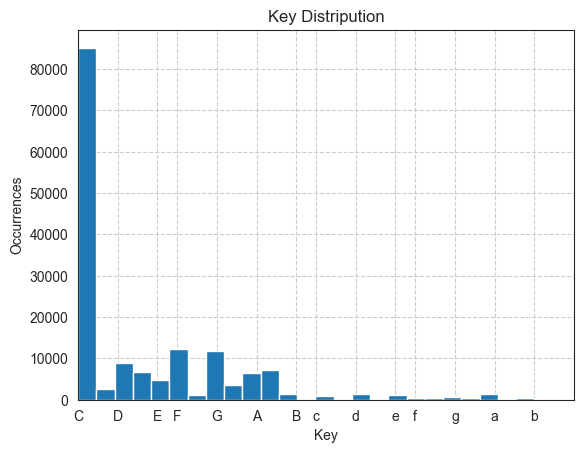

In [95]:
fig, ax = plt.subplots()
ax.hist([i for s in statistics for i in s['key_numbers']], bins=25)

ax.set_xticks([0, 2, 4, 5, 7, 9, 11, 12, 14, 16, 17, 19, 21, 23],
           ['C', 'D', 'E', 'F', 'G', 'A', 'B', 'c', 'd', 'e', 'f', 'g', 'a', 'b'])

ax.set_xlim(0,25)
ax.set_ylabel("Occurrences")
ax.set_xlabel("Key")
ax.grid( linestyle="--")
ax.set_title("Key Distribution")
plt.show()
